In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pickle
import gentrl
import numpy as np

import susi
from susi.SOMPlots import plot_estimation_map, plot_som_histogram, plot_umatrix
import gentrl
import torch
#torch.cuda.set_device(0)

In [2]:
enc = gentrl.RNNEncoder(latent_size=50)
dec = gentrl.DilConvDecoder(latent_input_size=50)
model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
#model.cuda();

C:\Users\mored\Miniconda3\envs\leishnn\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [22]:
# Load from past
model.load('modela/4.968215223985663==0.995')

C:\Users\mored\Miniconda3\envs\leishnn\lib\site-packages\torch\nn\modules\container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [4]:
som_general = pickle.load(open("general_leish_som_500K.p", "rb"))
som_specific = pickle.load(open("specific_leish_som_800K_2.p", "rb"))

In [5]:
from moses.metrics import mol_passes_filters, SA, logP
from moses.metrics.utils import get_n_rings, get_mol

from moses.utils import disable_rdkit_log
disable_rdkit_log()

def get_num_rings_6(mol):
    r = mol.GetRingInfo()
    return len([x for x in r.AtomRings() if len(x) > 6])


def penalized_logP(mol_or_smiles, masked=False, default=-5):
    mol = get_mol(mol_or_smiles)
    if mol is None:
        return default
    smiles_tokenized = gentrl.tokenizer.encode([mol_or_smiles])[0][0].tolist()
    general_award = 0.03*som_general.predict([smiles_tokenized])[0]
    specific_award = 1.4*som_specific.predict([smiles_tokenized])[0]
    reward = logP(mol) - SA(mol) - get_num_rings_6(mol) + specific_award + general_award
    if masked and not mol_passes_filters(mol):
        return default
    return reward

In [23]:
generated = []
sampled_valid = []
while len(generated) < 1000:
    sampled = model.sample(100)
    sampled_valid = [s for s in sampled if get_mol(s)]
    
    generated += sampled_valid

C:\Users\mored\Miniconda3\envs\leishnn\lib\site-packages\gentrl-0.1-py3.8.egg\gentrl\lp.py:108: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:25.)


In [24]:
sampled_valid = list(set(sampled_valid))
valid = sorted(sampled_valid, key=penalized_logP, reverse=True)

In [29]:
smiles_tokenized = gentrl.tokenizer.encode([valid[0]])[0][0].tolist()
som_general.predict([smiles_tokenized])[0]

10.166744239849129

In [32]:
logP(get_mol(valid[0]))

7.040340000000006

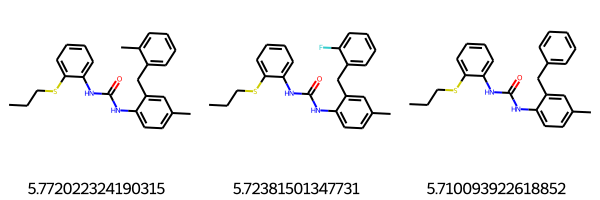

In [34]:
Draw.MolsToGridImage([get_mol(s) for s in valid[:3]], 
                     legends=[str(penalized_logP(s)) for s in valid[:3]])